In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../interception_events_new.csv", index_col=[0])

df_sel = df.dropna(subset=["ball_x", "ball_y"] + [f"{i}_x" for i in range(22)])

In [3]:
recep_x = []
recep_y = []

players_id = [f"{i}_player_id" for i in range(22)]

for i, row in df_sel.iterrows():
    for c in players_id:
        if row[c] == row["target_player"]:
            i = c.split("_")[0]
            recep_x.append(row[f"{i}_x"])
            recep_y.append(row[f"{i}_y"])
            break
    else:
        recep_x.append(np.nan)
        recep_y.append(np.nan)

df_sel.loc[:, "receptor_x"] = np.array(recep_x)
df_sel.loc[:, "receptor_y"] = np.array(recep_y)

df_sel = df_sel.dropna(subset=["receptor_x"]).reset_index(drop=True)

C:\Users\tonim\AppData\Local\Temp\ipykernel_12460\2255746938.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.loc[:, "receptor_x"] = np.array(recep_x)
C:\Users\tonim\AppData\Local\Temp\ipykernel_12460\2255746938.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.loc[:, "receptor_y"] = np.array(recep_y)


## Funções

In [22]:
class player(object):
    """
    player() class
    
    Class defining a player object that stores position, velocity, time-to-intercept and pitch control contributions for a player
    
    __init__ Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    

    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected time_to_intercept
    
    """
    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self,pid,team,teamname,params,GKid):
        self.id = pid
        self.is_gk = self.id == GKid
        self.teamname = teamname
        self.playername = pid
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_att = params['lambda_att'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_def = params['lambda_gk'] if self.is_gk else params['lambda_def'] # factor of 3 ensures that anything near the GK is likely to be claimed by the GK
        self.get_position(team)
        self.get_velocity(team)
        self.PPCF = 0. # initialise this for later
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'_x'], team[self.playername+'_y'] ] )
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'_vx'], team[self.playername+'_vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

In [23]:
def initialise_players(team,teamname,params,GKid):
    player_ids = np.unique([c.split('_')[0] for c in team.keys()])
    
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player = player(p,team, teamname,params,GKid)
        if team_player.inframe:
            team_players.append(team_player)
    return team_players

In [24]:
def find_goalkeeper(team, teamname):
    '''
    Find the goalkeeper in team, identifying him/her as the player closest to goal at kick off
    ''' 
    xcolumns = [f"{i}_x" for i in range(11)] if teamname == 1.0 else [f"{i}_x" for i in range(11, 22)]
    
    GK_col = team.iloc[0][xcolumns].abs().idxmax()
    return GK_col.split('_')[0]

In [25]:
def find_playing_direction(team,teamname):
    '''
    Find the direction of play for the team (based on where the goalkeepers are at kickoff). +1 is left->right and -1 is right->left
    '''    
    GK_column_x = find_goalkeeper(team, teamname)+"_x"
    # +ve is left->right, -ve is right->left
    return -np.sign(team.iloc[0][GK_column_x])

In [26]:
def to_single_playing_direction(home,away,events):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    second_half_idx = events.query("period == 2").index
    home.loc[second_half_idx, :] *= -1
    away.loc[second_half_idx, :] *= -1
        
    return home,away,events

In [27]:
def check_offsides( attacking_players, defending_players, ball_position, GK_numbers, verbose=False, tol=0.2):
    """
    check_offsides( attacking_players, defending_players, ball_position, GK_numbers, verbose=False, tol=0.2):
    
    checks whetheer any of the attacking players are offside (allowing for a 'tol' margin of error). Offside players are removed from 
    the 'attacking_players' list and ignored in the pitch control calculation.
    
    Parameters
    -----------
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_position: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
        verbose: if True, print a message each time a player is found to be offside
        tol: A tolerance parameter that allows a player to be very marginally offside (up to 'tol' m) without being flagged offside. Default: 0.2m
            
    Returrns
    -----------
        attacking_players: list of 'player' objects for the players on the attacking team with offside players removed
    """    
    defending_GK_id = GK_numbers[1] if attacking_players[0].teamname==1.0 else GK_numbers[0]
    
    assert defending_GK_id in [p.id for p in defending_players], "Defending goalkeeper jersey number not found in defending players"
    
    defending_GK = [p for p in defending_players if p.id==defending_GK_id][0]  
    defending_half = np.sign(defending_GK.position[0])
    
    second_deepest_defender_x = sorted([defending_half*p.position[0] for p in defending_players], reverse=True)[1]

    offside_line = max(second_deepest_defender_x,defending_half*ball_position[0],0.0)+tol
    if verbose:
        for p in attacking_players:
            if p.position[0]*defending_half>offside_line:
                print("player %s in %s team is offside" % (p.id, p.playername))
                
    attacking_players = [p for p in attacking_players if p.position[0]*defending_half<=offside_line]
    return attacking_players

In [28]:
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )

    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

In [29]:
def generate_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 40, offsides=True):
    """ generate_pitch_control_for_event
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        offsides: If True, find and remove offside atacking players from the calculation. Default is True.
        
    UPDATE (tutorial 4): Note new input arguments ('GK_numbers' and 'offsides')
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)

    """
    # get the details of the event (frame, team in possession, ball_start_position)
    pass_team = events.loc[event_id, "home_ball"]
    ball_start_pos = np.array([events.loc[event_id]['ball_x'],events.loc[event_id]['ball_y']])
    
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if pass_team==1.0:
        attacking_players = initialise_players(tracking_home.loc[event_id],1.0,params,GK_numbers[0])
        defending_players = initialise_players(tracking_away.loc[event_id],0.0,params,GK_numbers[1])
    elif pass_team==0.0:
        defending_players = initialise_players(tracking_home.loc[event_id],1.0,params,GK_numbers[0])
        attacking_players = initialise_players(tracking_away.loc[event_id],0.0,params,GK_numbers[1])
    else:
        assert False, "Team in possession must be either home or away"
        
    # find any attacking players that are offside and remove them from the pitch control calculation
    if offsides:
        attacking_players = check_offsides( attacking_players, defending_players, ball_start_pos, GK_numbers)
    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid

In [84]:
def plot_pitch(field_dimen = (105.0,68.0), field_color ='green', linewidth=1, markersize=10):
    fig,ax = plt.subplots(figsize=(3,2.25)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

def plot_frame(hometeam, awayteam, ball_pos, recep_pos, figax=None, team_colors=('r','b'), field_dimen = (105.0,68.0), include_player_velocities=False, PlayerMarkerSize=2, PlayerAlpha=0.5, annotate=False ):
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    
    for team,teamname, color in zip([hometeam,awayteam], [1.0, 0.0], team_colors) :
        x_columns = [f"{i}_x" for i in range(11)] if teamname == 1.0 else [f"{i}_x" for i in range(11, 22)]
        y_columns = [f"{i}_y" for i in range(11)] if teamname == 1.0 else [f"{i}_y" for i in range(11, 22)]
        
        ax.plot( team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = [f"{i}_vx" for i in range(11)] if teamname == 1.0 else [f"{i}_x" for i in range(11, 22)]
            vy_columns = [f"{i}_vy" for i in range(11)] if teamname == 1.0 else [f"{i}_x" for i in range(11, 22)]
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot(ball_pos['ball_x'], ball_pos['ball_y'], 'yo', markersize=5, alpha=0.7, linewidth=0)
    #plot receptor
    ax.plot(recep_pos['receptor_x'], recep_pos['receptor_y'], 'go', markersize=5, alpha=0.7, linewidth=0)

    ax.plot((ball_pos["ball_x"], recep_pos['receptor_x']), (ball_pos["ball_y"], recep_pos['receptor_y']), linewidth=1, color="white")
    return fig,ax

In [31]:
def plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF, alpha = 0.7, include_player_velocities=False, annotate=False, field_dimen = (105.0,68)):
    # pick a pass at which to generate the pitch control surface
    pass_frame = event_id
    pass_team = events.loc[event_id]["home_ball"]
    
    # plot frame and event
    fig,ax = plot_pitch(field_color='white', field_dimen = field_dimen)
    plot_frame(
        tracking_home.loc[pass_frame], 
        tracking_away.loc[pass_frame], 
        events.loc[event_id, ["ball_x", "ball_y"]], 
        events.loc[event_id, ["receptor_x", "receptor_y"]],
        figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    # plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
    
    # plot pitch control surface
    if pass_team==1.0:
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    fig.tight_layout(pad=0)
    ax.axis("off")
    return fig,ax

In [32]:
def default_model_params(time_to_control_veto=3):
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['lambda_gk'] = params['lambda_def']*3.0 # make goal keepers must quicker to control ball (because they can catch it)
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

## Fazendo

In [33]:
game_id = df_sel.iloc[0]["game_id"]

game_events = df_sel.query(f"game_id == {game_id}")

home = game_events[[f"{i}_x" for i in range(11)] + [f"{i}_y" for i in range(11)] + [f"{i}_vx" for i in range(11)] + [f"{i}_vy" for i in range(11)]]
away = game_events[[f"{i}_x" for i in range(11, 22)] + [f"{i}_y" for i in range(11, 22)] + [f"{i}_vx" for i in range(11, 22)] + [f"{i}_vy" for i in range(11, 22)]]

In [85]:
from tqdm import tqdm 
params = default_model_params()

home_playing_direction = find_playing_direction(home, 1.0)
away_playing_direction = find_playing_direction(away, 0.0)

home, away, _ = to_single_playing_direction(home,away,game_events)

GKs = find_goalkeeper(home, 1.0), find_goalkeeper(away, 0.0)

fields = []
for event_id in tqdm(game_events.index[:1]):
    PCFF, xgrid, ygrid = generate_pitch_control_for_event(event_id, game_events, home, away, params, GKs)
    fig, ax = plot_pitchcontrol_for_event(event_id, game_events,  home, away, PCFF, annotate=False)

    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    rgb_string = fig.canvas.tostring_rgb()
    rgb_array = np.frombuffer(rgb_string, dtype=np.uint8).reshape(height, width, 3)
    fields.append(rgb_array)

    plt.close('all')

C:\Users\tonim\AppData\Local\Temp\ipykernel_12460\3766729019.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home.loc[second_half_idx, :] *= -1
C:\Users\tonim\AppData\Local\Temp\ipykernel_12460\3766729019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away.loc[second_half_idx, :] *= -1
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


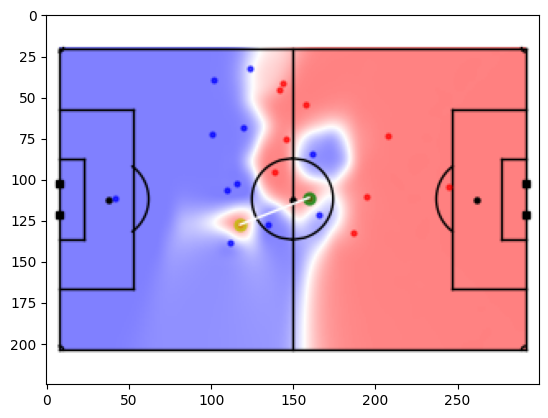

In [86]:
plt.imshow(fields[0])

In [81]:
np.save('X.npy', np.array(fields))

## Modelos

In [6]:
fields = np.load("X.npy")

In [43]:
X = np.array(fields, dtype=np.float32)

In [44]:
game_events.loc[:, "pass_outcome_type"] = df["pass_outcome_type"].str.replace("B", "D")
game_events = game_events[~((game_events["pass_outcome_type"] == "O") | (game_events["pass_outcome_type"] == "S"))]
game_events["Y"] = (game_events["pass_outcome_type"] == "D").astype(int)

C:\Users\tonim\AppData\Local\Temp\ipykernel_12460\1912201907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_events["Y"] = (game_events["pass_outcome_type"] == "D").astype(int)


In [45]:
X = X[game_events.index]
y = game_events["Y"].values

In [54]:
from tensorflow.keras.utils import to_categorical
y_hot = to_categorical(y, num_classes=2)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_hot, test_size=0.2, random_state=42
)

X_train /= 255.0
X_test /= 255.0

In [76]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential()

# Add a convolutional layer
model.add(layers.Conv2D(4, (5, 5), activation='relu', input_shape=(225, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Add more convolutional layers
model.add(layers.Conv2D(8, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

In [72]:
1 - y.mean()

0.8609566184649611

In [77]:
model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    class_weight=class_weights
)

Epoch 1/5
12/12 [==============================] - 14s 1s/step - loss: 0.6819 - accuracy: 0.3268
Epoch 2/5
12/12 [==============================] - 15s 1s/step - loss: 0.6772 - accuracy: 0.8693
Epoch 3/5
12/12 [==============================] - 15s 1s/step - loss: 0.6765 - accuracy: 0.8693
Epoch 4/5
12/12 [==============================] - 15s 1s/step - loss: 0.6754 - accuracy: 0.8693
Epoch 5/5
12/12 [==============================] - 15s 1s/step - loss: 0.6761 - accuracy: 0.8693


In [80]:
np.argmax(model.predict(X_test), axis=1)

6/6 [==============================] - 1s 118ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

classification_report(y_test, np.argmax(model.predict(X_test), axis=1), output_dict=True)

6/6 [==============================] - 1s 140ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets